# Doppler Broadened Case

### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Image
from scipy.optimize import fsolve
from scipy.linalg import LinAlgError, solve
from scipy.special import erfinv
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from matplotlib.ticker import MaxNLocator

## Parameters

In [9]:
# Constants
epsilon_0 = 8.854e-12  # Vacuum permittivity (F/m)
hbar = 1.054e-34       # Reduced Planck's constant (J·s)
mu_13 = 1.366e-29     # Dipole moment between states (|1> and |3>) (C·m)
mu_23 = 1.058e-29     # Dipole moment between states (|2> and |3>) (C·m)
lambda1 = 795e-9       # In m
c = 3e8

Gamma3 = 2 * np.pi * 6   # (MHz)
Gamma31 = 0.5 * Gamma3   # Decay from level 3 to level 1 (MHz)
Gamma32 = Gamma23 = 0.5 * Gamma3   # Decay from level 3 to level 2 (MHz)

w_1 = 2 * np.pi * 3.771120414e14
w_2 = 2 * np.pi * 3.771052067e14
k_1 = w_1 / 3e8
k_2 = w_2 / 3e8
L = 0.02        # Length in meters
z = 0.00001    # Step size in meters
w0 = 71e-6          # In m

k_b = 1.380649e-23     # Boltzmann constant (m^2 kg s^-2 K^-1)
m = 1.41e-25           # Mass of the particle (kg)
T = 356                # Temperature (K)

if T > (273 + 39.3):
    P = 10**(2.881 + 4.312 - 4040/T)
    
else:
    P = 10**(2.881 + 4.857 - 4215/T)

print("Vapor Pressure: " + str(P))
N = P * 133.32 / (k_b * T)
OD_0 = N*L*(2 * (np.pi)**2 * np.abs(mu_13)**2) / (hbar * epsilon_0 * w_1 * lambda1) * np.sqrt(m * c**2 / (2 * np.pi * k_b * T)) 
print("N_vapor = {:.2e}".format(N))
print("OD of vapor: " + str(OD_0))

coll_rate = N * np.sqrt(8*k_b*T/(np.pi*m)) * 1.11594e-18      # gamma = N * v * sigma
print("Collision rate = {:.2e} MHz".format(coll_rate / 1e6))

Gamma12 = Gamma21 = 2.22e-2    # Decay rates between levels 1 and 2 (MHz)
gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (MHz)
gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (MHz)
gamma12 = (Gamma12 + Gamma21)/2      # Decoherence rate between ground states (MHz)

# Thermal velocity standard deviation (Sigma)
sigma = np.sqrt(k_b * T / m)

print(np.sqrt(8*k_b*T/(np.pi*m)))

Vapor Pressure: 6.993352078894923e-05
N_vapor = 1.90e+18
OD of vapor: 50.95481910267923
Collision rate = 6.31e-04 MHz
297.93885276191685


# Maxwell-Boltzmann Distribution

Total area under Maxwellian: 0.9990078668740994


C:\Users\ruben\AppData\Local\Temp\ipykernel_46436\843965116.py:31: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  V_solution = fsolve(func, V_guess, xtol=1e-8, maxfev=100000)[0]


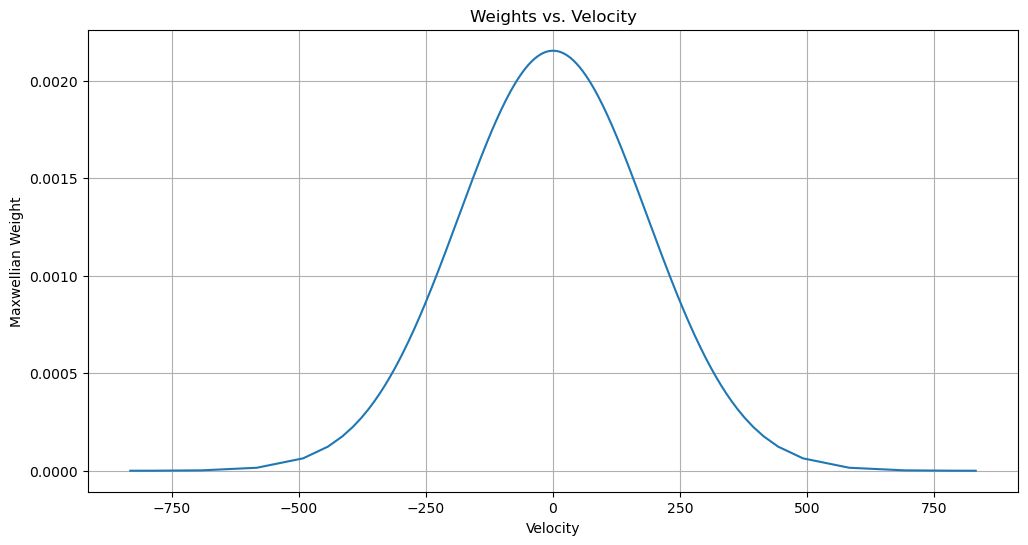

In [3]:
# Maxwell-Boltzmann distribution function
def Maxwellian(V):
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-V**2 / (2 * sigma**2))

# Number of velocity points
nv = 251
v_values = np.zeros(nv)
dv = np.zeros(nv)
dv_min = 0.95  # Reduced minimum velocity increment for better resolution

# Middle index (centered at zero velocity)
mid_index = nv // 2
v_values[mid_index] = 0
dv[mid_index] = dv_min * 2

# Area under Maxwellian at zero velocity
area = dv[mid_index] * Maxwellian(0)

# Compute positive velocities
for m in range(mid_index + 1, nv):
    v_end = v_values[m - 1] + dv[m - 1] / 2

    # Define the function to find the root of
    def func(V):
        return Maxwellian((V + v_end) / 2) * (V - v_end) - area

    # Improved initial guess for V
    V_guess = v_end + dv_min

    # Use fsolve to find V such that func(V) = 0
    V_solution = fsolve(func, V_guess, xtol=1e-8, maxfev=100000)[0]

    # Update velocity and dv arrays
    v_values[m] = (V_solution + v_end) / 2
    dv[m] = V_solution - v_end

# Reflect to get negative velocities
v_values[:mid_index] = -np.flip(v_values[mid_index + 1:])
dv[:mid_index] = np.flip(dv[mid_index + 1:])

# Maxwell-Boltzmann distribution weights
weights = Maxwellian(v_values)

#print(v_values)
#print(weights)

# Verify that the total area under the curve approximates 1
total_area = np.sum(weights * dv)
print('Total area under Maxwellian:', total_area)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(v_values, weights)
plt.title('Weights vs. Velocity')
plt.xlabel('Velocity')
plt.ylabel('Maxwellian Weight')
plt.grid(True)
plt.show()

## Main Code

In [36]:
# Backend function to calculate OD based on user input
def calculate_OD_1(Om_1=1.0, delta_1=0.0, delta_2=0.0):
    n_rabi = 25
    Om_2_list_adapted = np.linspace(0, 5 * Gamma3, n_rabi, dtype=complex)  # Coupling Rabi frequency range (dimensionless)
    Om_2_list = Om_2_list_adapted.copy()
    Om_1_list = np.full(n_rabi, Om_1, dtype=complex)
    
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = []
    Om_1_vs_z = []

    for i in range(nz):
        if i == nz//4 or i == nz//2 or i == 3*nz//4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(len(Om_2_list)):
            
            # Initialize arrays to store rho31 and rho32
            rho31_values = []
            rho32_values = []

            for k in range(len(v_values)):                   

                Om_2_actual = Om_2_list[j]      # Convert to actual Omega_2 in MHz
                Om_1_actual = Om_1_list[j]      # Convert Om_1 to MHz

                delta_1_actual = delta_1 + k_1 * v_values[k] / (10**6)
                delta_2_actual = delta_2 + k_2 * v_values[k] / (10**6)

                # Define the imaginary unit
                I = 1j

                # Construct the matrix A
                A = np.array([
                    # Row 1
                    [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                    # Row 2
                    [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                    # Row 3
                    [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                    # Row 4
                    [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                    # Row 5
                    [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                    # Row 6
                    [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                    # Row 7
                    [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                    # Row 8
                    [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
                ], dtype=complex)

                # Construct the vector b
                b = np.array([
                    Gamma31,
                    0,
                    I*np.conjugate(Om_1_actual)/2,
                    0,
                    Gamma32,
                    I*np.conjugate(Om_2_actual)/2,
                    -I*Om_1_actual/2,
                    -I*Om_2_actual/2
                ], dtype=complex)

                try:
                    v = np.linalg.solve(A, b)
                except np.linalg.LinAlgError:
                    # Handle singular matrix
                    print(f"Singular matrix at z step {i}, velocity index {k}")
                    rho31 = np.nan
                    rho32 = np.nan
                else:
                    # Extract the solutions
                    rho11 = np.real(v[0])
                    rho12 = v[1]
                    rho13 = v[2]
                    rho21 = v[3]
                    rho22 = np.real(v[4])
                    rho23 = v[5]
                    rho31 = v[6]
                    rho32 = v[7]

                # Compute rho33
                rho33 = 1 - rho11 - rho22

                # Store the populations
                rho31_values.append(rho31)
                rho32_values.append(rho32)  

            # Compute the weighted sums using dot product
            rho32_val = np.sum(rho32_values * weights * dv)
            rho31_val = np.sum(rho31_values * weights * dv)

            # Update the Rabi frequencies
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_2 / (epsilon_0 * hbar)) * N * rho32_val * mu_23**2 / (10**6)
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_1 / (epsilon_0 * hbar)) * N * rho31_val * mu_13**2 / (10**6)

        # Record Rabi frequencies at this z step
        Om_2_vs_z.append(Om_2_list.copy())
        Om_1_vs_z.append(Om_1_list.copy())

    # Convert lists to numpy arrays
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    Om_1_vs_z = np.array(Om_1_vs_z)
    
    return Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted, Om_2_list

def plot_OD(Om_1: list,delta_1: list, delta_2):
    
    # Calculate power required for Ω1
    w0 = 71e-6  # Beam waist in meters
    P = (np.pi * c * epsilon_0 * (Om_1 * 1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)
    print("Power required = {:.2e} W".format(P))
    
    # Calculate the Rabi frequency evolution
    Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted, Om_2_list = calculate_OD_1(Om_1, delta_1, delta_2)
    
    # Calculate input intensities
    Input_Intensity_Omega_1 = 0.5 * c * epsilon_0 * (Om_1 * 1e6 * hbar / mu_13)**2
    Input_Intensity_Omega_2 = 0.5 * c * epsilon_0 * (Om_2_list_adapted * 1e6 * hbar / mu_23)**2  
    
    # Calculate output intensities (final z-step) for Ω1 and Ω2
    Output_Intensity_Omega_1 = 0.5 * c * epsilon_0 * (np.abs(Om_1_vs_z[-1, :]) * 1e6 * hbar / mu_13)**2
    Output_Intensity_Omega_2 = 0.5 * c * epsilon_0 * (np.abs(Om_2_vs_z[-1, :]) * 1e6 * hbar / mu_23)**2  
    
    # --- Plot 1: Final Ω1 vs initial Ω2 ---
    plt.figure(figsize=(8, 6))
    plt.plot(np.real(Om_2_list_adapted),
             np.abs(Om_1_vs_z[-1, :]),
             color='blue',
             label='Output Intensity $\\Omega_1$')
    plt.xlabel('$\\Omega_{2,\\mathrm{in}}$')
    plt.ylabel('$\\Omega_{1,\\mathrm{out}}$')
    plt.title('$\\Omega_{1,\\mathrm{out}}$ vs. variable $\\Omega_{2,\\mathrm{in}}$')
    plt.grid(True)
    plt.show()

    # --- Plot 2: Final Ω2 vs initial Ω2 ---
    plt.figure(figsize=(8, 6))
    plt.plot(np.real(Om_2_list_adapted),
             np.abs(Om_2_vs_z[-1, :]),
             color='red',
             label='Output Intensity $\\Omega_2$')
    plt.xlabel('$\\Omega_{2,\\mathrm{in}}$')
    plt.ylabel('$\\Omega_{2,\\mathrm{out}}$')
    plt.title('$\\Omega_{2,\\mathrm{out}}$ vs. variable $\\Omega_{2,\\mathrm{in}}$')
    plt.grid(True)
    plt.show()
    
    # --- Plot 3: Final I1 vs. initial I2 ---
    plt.figure(figsize=(8, 6))
    plt.plot(Input_Intensity_Omega_2,
             Output_Intensity_Omega_1,
             color='blue',
             label=(
                 f'$I_{{1,\\mathrm{{in}}}}$={Input_Intensity_Omega_1:.2e} (W/m$^2$)\n'
                 f'$\\Delta_1$={delta_1} MHz\n'
                 f'$\\Delta_2$={delta_2} MHz'
             ))
    plt.xlabel('Initial Intensity 2 ($I_{2,\\mathrm{in}}$) (W/m$^2$)')
    plt.ylabel('Output Intensity 1 ($I_{1,\\mathrm{out}}$) (W/m$^2$)')
    plt.title('$I_{1,\\mathrm{out}}$ vs. $I_{2,\\mathrm{in}}$')
    plt.grid(True)
    plt.legend()
    plt.show()

    # --- Plot 4: Final I2 vs. initial I2 ---
    plt.figure(figsize=(8, 6))
    plt.plot(Input_Intensity_Omega_2,
             Output_Intensity_Omega_2,
             color='red',
             label=(
                 f'$I_{{1,\\mathrm{{in}}}}$={Input_Intensity_Omega_1:.2e} (W/m$^2$)\n'
                 f'$\\Delta_1$={delta_1} MHz\n'
                 f'$\\Delta_2$={delta_2} MHz'
             ))
    plt.xlabel('Initial Intensity 2 ($I_{2,\\mathrm{in}}$) (W/m$^2$)')
    plt.ylabel('Output Intensity 2 ($I_{2,\\mathrm{out}}$) (W/m$^2$)')
    plt.title('$I_{2,\\mathrm{out}}$ vs. $I_{2,\\mathrm{in}}$')
    plt.grid(True)
    plt.legend()
    plt.show()
    
# Adjust slider description width specifically
slider_layout = widgets.Layout(width='800px')  # Adjust slider width if needed
description_layout = widgets.Layout(width='150px')  # Adjust description width

# Interactive sliders for Om_1, delta_1, delta_2 with wider description layout
Om_1_slider = widgets.FloatSlider(
    value=37, min=0.000000001, max=500.0, step=0.01,
    description=r'$\Omega_1$ (MHz)', layout=slider_layout,
    style={'description_width': '150px'}  # This sets description width
)

delta_1_slider = widgets.FloatSlider(
    value=10.0, min=-50, max=150, step=0.01,
    description=r'$\Delta_1$ (MHz)', layout=slider_layout,
    style={'description_width': '150px'}  # Adjust description width
)

delta_2_slider = widgets.FloatSlider(
    value=0.0, min=-50, max=150, step=0.01,
    description=r'$\Delta_2$ (MHz)', layout=slider_layout,
    style={'description_width': '150px'}  # Adjust description width
)

# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_1 = 37
    delta_1 = 0
    delta_2 = 2
    
    # Call the plot_OD function with these values
    plot_OD(Om_1, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(Om_1_slider, delta_1_slider, delta_2_slider, run_button)


FloatSlider(value=37.0, description='$\\Omega_1$ (MHz)', layout=Layout(width='800px'), max=500.0, min=1e-09, s…

FloatSlider(value=10.0, description='$\\Delta_1$ (MHz)', layout=Layout(width='800px'), max=150.0, min=-50.0, s…

FloatSlider(value=0.0, description='$\\Delta_2$ (MHz)', layout=Layout(width='800px'), max=150.0, min=-50.0, st…

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

### Scanning Values

In [9]:
# Backend function to calculate OD based on user input
def calculate_OD_1(Om_1=1.0, delta_1=0.0, delta_2=0.0, Gamma12=0):
    n_rabi = 100
    Gamma21 = Gamma12    # Decay rates between levels 1 and 2 (MHz)
    gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (MHz)
    gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (MHz)
    gamma12 = (Gamma12 + Gamma21)/2      # Decoherence rate between ground states (MHz)
    Om_2_list_adapted = np.linspace(0, np.sqrt(100 * Gamma3**2), n_rabi, dtype=complex)  # Coupling Rabi frequency range (dimensionless)
    Om_2_list = Om_2_list_adapted.copy()
    Om_1_list = np.full(n_rabi, Om_1, dtype=complex)
    
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = []
    Om_1_vs_z = []

    for i in range(nz):
        if i == nz//4 or i == nz//2 or i == 3*nz//4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(len(Om_2_list)):
            
            # Initialize arrays to store rho31 and rho32
            rho31_values = []
            rho32_values = []

            for k in range(len(v_values)):                   

                Om_2_actual = Om_2_list[j]      # Convert to actual Omega_2 in MHz
                Om_1_actual = Om_1_list[j]      # Convert Om_1 to MHz

                delta_1_actual = delta_1 + k_1 * v_values[k] / (10**6)
                delta_2_actual = delta_2 + k_2 * v_values[k] / (10**6)

                # Define the imaginary unit
                I = 1j

                # Construct the matrix A
                A = np.array([
                    # Row 1
                    [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                    # Row 2
                    [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                    # Row 3
                    [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                    # Row 4
                    [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                    # Row 5
                    [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                    # Row 6
                    [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                    # Row 7
                    [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                    # Row 8
                    [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
                ], dtype=complex)

                # Construct the vector b
                b = np.array([
                    Gamma31,
                    0,
                    I*np.conjugate(Om_1_actual)/2,
                    0,
                    Gamma32,
                    I*np.conjugate(Om_2_actual)/2,
                    -I*Om_1_actual/2,
                    -I*Om_2_actual/2
                ], dtype=complex)

                try:
                    v = np.linalg.solve(A, b)
                except np.linalg.LinAlgError:
                    # Handle singular matrix
                    print(f"Singular matrix at z step {i}, velocity index {k}")
                    rho31 = np.nan
                    rho32 = np.nan
                else:
                    # Extract the solutions
                    rho11 = np.real(v[0])
                    rho12 = v[1]
                    rho13 = v[2]
                    rho21 = v[3]
                    rho22 = np.real(v[4])
                    rho23 = v[5]
                    rho31 = v[6]
                    rho32 = v[7]

                # Compute rho33
                rho33 = 1 - rho11 - rho22

                # Store the populations
                rho31_values.append(rho31)
                rho32_values.append(rho32)  

            # Compute the weighted sums using dot product
            rho32_val = np.sum(rho32_values * weights * dv)
            rho31_val = np.sum(rho31_values * weights * dv)

            # Update the Rabi frequencies
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_2 / (epsilon_0 * hbar)) * N * rho32_val * mu_23**2 / (10**6)
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_1 / (epsilon_0 * hbar)) * N * rho31_val * mu_13**2 / (10**6)

        # Record Rabi frequencies at this z step
        Om_2_vs_z.append(Om_2_list.copy())
        Om_1_vs_z.append(Om_1_list.copy())

    # Convert lists to numpy arrays
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    Om_1_vs_z = np.array(Om_1_vs_z)
    
    return Om_2_list, Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted

# Suppose mu_2 is mu_23 for Omega_2, mu_1 is mu_13 for Omega_1
K_2 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_23**2)
K_1 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)

# For the X-axis (which is Omega_2^2 -> power):
def x_forward(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2) # because P = K_2 * (omega2)^2
def x_inverse(power_value):
    return power_value / (K_2 * (Gamma3**2))
# For the Y-axis (which is Omega_1^2 -> power):
def y_forward(omega1_sq):
    return K_1 * omega1_sq * (Gamma3**2)
def y_inverse(power_value):
    return power_value / (K_1 * (Gamma3**2))
def y_forward_2(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2)  # Por ejemplo, si K_2 corresponde a la transición de Ω2
def y_inverse_2(power_value):
    return power_value / (K_2 * (Gamma3**2))

def plot_OD(Om_1, delta_1, delta_2):
    
    Output_Omega_1_list = [0]*len(delta_1)
    Output_Omega_2_list = [0]*len(delta_1)
    
    Gamma12_list = np.array([0, 0.1])*Gamma3
    
    for i in range(len(delta_1)):    
        Om_2_list, Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted = calculate_OD_1(Om_1[i], delta_1[i], delta_2[i], Gamma12_list[i])
        Output_Omega_1_list[i] = np.abs(Om_1_vs_z[-1, :])
        Output_Omega_2_list[i] = np.abs(Om_2_vs_z[-1, :])
    
    print((np.array(Output_Omega_1_list)).tolist())
    print((np.array(Output_Omega_2_list)).tolist())
    
    fig, ax1 = plt.subplots(figsize=(8,6))
    for i in range(len(delta_1)):
        ax1.plot((np.real(Om_2_list_adapted))**2/Gamma3**2,
                 (Output_Omega_1_list[i])**2/Gamma3**2,
                 label=f'$\\Delta_2$={delta_2[i]:.1f} MHz')

    ax1.set_xlabel(r'$\left(\frac{\Omega_{2,\mathrm{in}}}{\Gamma_3}\right)^2$')
    ax1.set_ylabel(r'$\left(\frac{\Omega_{1,\mathrm{out}}}{\Gamma_3}\right)^2$')
    ax1.grid(True)
    ax1.legend(loc='best')

    # Create the top X-axis for power of Omega_2:
    ax_top = ax1.secondary_xaxis('top', functions=(x_forward, x_inverse))
    ax_top.set_xlabel('Input Power for $\\Omega_2$ (W)')

    # Create the right Y-axis for power of Omega_1:
    ax_right = ax1.secondary_yaxis('right', functions=(y_forward, y_inverse))
    ax_right.set_ylabel('Output Power for $\\Omega_1$ (W)')
    # Save the figure to the specified path
    save_path = r"C:\Users\ruben\OneDrive\Escritorio\Purdue\AONN Research\Paper Figures\Figure7b.pdf"
    plt.savefig(save_path, format='eps', dpi=300)
    plt.show()

    fig, ax2 = plt.subplots(figsize=(8,6))
    for i in range(len(delta_1)):
        ax2.plot((np.real(Om_2_list_adapted))**2/Gamma3**2,
                 (Output_Omega_2_list[i])**2/Gamma3**2,
                 label=f'$\\Delta_2$={delta_2[i]:.1f} MHz')

    ax2.set_xlabel(r'$\left(\frac{\Omega_{2,\mathrm{in}}}{\Gamma_3}\right)^2$')
    ax2.set_ylabel(r'$\left(\frac{\Omega_{2,\mathrm{out}}}{\Gamma_3}\right)^2$')
    ax2.grid(True)
    ax2.legend(loc='best')

    # Top X-axis for input power (still use x_forward / x_inverse for the coupling beam’s dipole moment mu_23):
    ax2_top = ax2.secondary_xaxis('top', functions=(x_forward, x_inverse))
    ax2_top.set_xlabel('Input Power for $\\Omega_2$ (W)')

    # Right Y-axis for output power (again use mu_23, because it’s the same beam if it’s $\Omega_2$):
    ax2_right = ax2.secondary_yaxis('right', functions=(y_forward_2, y_inverse_2))  
    # or if you want the same function names but with mu_23 inside, define them accordingly.
    ax2_right.set_ylabel('Output Power for $\\Omega_2$ (W)')
    save_path = r"C:\Users\ruben\OneDrive\Escritorio\Purdue\AONN Research\Paper Figures\Figure7a.pdf"
    plt.savefig(save_path, format='eps', dpi=300)
    plt.show()
    

# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_1 = np.array([1, 1])*Gamma3
    delta_1 = np.array([1/8, 1/8])*Gamma3
    delta_2 = -1 * delta_1
    
    # Call the plot_OD function with these values
    plot_OD(Om_1, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(run_button)

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

### Now variable laser 1

In [13]:
# Backend function to calculate OD based on user input
def calculate_OD_1(Om_2=1.0, delta_1=0.0, delta_2=0.0):
    n_rabi = 100
    Om_1_list_adapted = np.linspace(0, 4 * Gamma3, n_rabi, dtype=complex)  # Coupling Rabi frequency range (dimensionless)
    Om_1_list = Om_1_list_adapted.copy()
    Om_2_list = np.full(n_rabi, Om_2, dtype=complex)
    
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = []
    Om_1_vs_z = []

    for i in range(nz):
        if i == nz//4 or i == nz//2 or i == 3*nz//4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(len(Om_1_list)):
            
            # Initialize arrays to store rho31 and rho32
            rho31_values = []
            rho32_values = []

            for k in range(len(v_values)):                   

                Om_2_actual = Om_2_list[j]      # Convert to actual Omega_2 in MHz
                Om_1_actual = Om_1_list[j]      # Convert Om_1 to MHz

                delta_1_actual = delta_1 + k_1 * v_values[k] / (10**6)
                delta_2_actual = delta_2 + k_2 * v_values[k] / (10**6)

                # Define the imaginary unit
                I = 1j

                # Construct the matrix A
                A = np.array([
                    # Row 1
                    [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                    # Row 2
                    [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                    # Row 3
                    [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                    # Row 4
                    [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                    # Row 5
                    [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                    # Row 6
                    [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                    # Row 7
                    [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                    # Row 8
                    [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
                ], dtype=complex)

                # Construct the vector b
                b = np.array([
                    Gamma31,
                    0,
                    I*np.conjugate(Om_1_actual)/2,
                    0,
                    Gamma32,
                    I*np.conjugate(Om_2_actual)/2,
                    -I*Om_1_actual/2,
                    -I*Om_2_actual/2
                ], dtype=complex)

                try:
                    v = np.linalg.solve(A, b)
                except np.linalg.LinAlgError:
                    # Handle singular matrix
                    print(f"Singular matrix at z step {i}, velocity index {k}")
                    rho31 = np.nan
                    rho32 = np.nan
                else:
                    # Extract the solutions
                    rho11 = np.real(v[0])
                    rho12 = v[1]
                    rho13 = v[2]
                    rho21 = v[3]
                    rho22 = np.real(v[4])
                    rho23 = v[5]
                    rho31 = v[6]
                    rho32 = v[7]

                # Compute rho33
                rho33 = 1 - rho11 - rho22

                # Store the populations
                rho31_values.append(rho31)
                rho32_values.append(rho32)  

            # Compute the weighted sums using dot product
            rho32_val = np.sum(rho32_values * weights * dv)
            rho31_val = np.sum(rho31_values * weights * dv)

            # Update the Rabi frequencies
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_2 / (epsilon_0 * hbar)) * N * rho32_val * mu_23**2 / (10**6)
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_1 / (epsilon_0 * hbar)) * N * rho31_val * mu_13**2 / (10**6)

        # Record Rabi frequencies at this z step
        Om_2_vs_z.append(Om_2_list.copy())
        Om_1_vs_z.append(Om_1_list.copy())

    # Convert lists to numpy arrays
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    Om_1_vs_z = np.array(Om_1_vs_z)
    
    return Om_2_list, Om_2_vs_z, Om_1_vs_z, z_array, Om_1_list_adapted

# Suppose mu_2 is mu_23 for Omega_2, mu_1 is mu_13 for Omega_1
K_2 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_23**2)
K_1 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)

# For the X-axis (which is Omega_2^2 -> power):
def x_forward(omega2_sq):
    return K_1 * omega2_sq * (Gamma3**2) # because P = K_2 * (omega2)^2
def x_inverse(power_value):
    return power_value / (K_1 * (Gamma3**2))
# For the Y-axis (which is Omega_1^2 -> power):
def y_forward(omega1_sq):
    return K_1 * omega1_sq * (Gamma3**2)
def y_inverse(power_value):
    return power_value / (K_1 * (Gamma3**2))
def y_forward_2(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2)  # Por ejemplo, si K_2 corresponde a la transición de Ω2
def y_inverse_2(power_value):
    return power_value / (K_2 * (Gamma3**2))

def plot_OD(Om_2, delta_1, delta_2):
    
    Output_Omega_1_list = [0]*len(delta_1)
    Output_Omega_2_list = [0]*len(delta_1)
    
    for i in range(len(delta_1)):    
        Om_2_list, Om_2_vs_z, Om_1_vs_z, z_array, Om_1_list_adapted = calculate_OD_1(Om_2[i], delta_1[i], delta_2[i])
        Output_Omega_1_list[i] = np.abs(Om_1_vs_z[-1, :])
        Output_Omega_2_list[i] = np.abs(Om_2_vs_z[-1, :])
        print((np.array(np.abs(Om_1_vs_z[-1, :]))).tolist())
        print((Om_1_list_adapted).tolist())
    

# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_2 = np.array([1])*Gamma3
    delta_1 = np.array([0])*Gamma3
    delta_2 = [0]
    
    # Call the plot_OD function with these values
    plot_OD(Om_2, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(run_button)

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

Processing z step 499/1999
Processing z step 999/1999
Processing z step 1499/1999
[0.0, 1.5112949253348533, 3.0155596931221114, 4.506047187170165, 5.976732115528249, 7.4227769532964345, 8.840834116946912, 10.229132980014892, 11.587395670950318, 12.916643634760607, 14.218947596971203, 15.497160743085464, 16.754662955268987, 17.9951333089125, 19.222359271754396, 20.44008461343089, 21.651893929157385, 22.861129519174813, 24.070835581061587, 25.283724721265948, 26.502162258161345, 27.7281644033279, 28.963407025389373, 30.209242257997282, 31.466720692150027, 32.736617295386154, 34.01945953654906, 35.315556476674146, 36.62502782546776, 37.94783216885513, 39.28379375393818, 40.63262737874643, 41.99396107813025, 43.367356424685156, 44.752326374171425, 46.148350677440696, 47.55488895474277, 48.97139158351321, 50.39730858834158, 51.83209674362411, 53.27522510781042, 54.7261792059397, 56.18446406697037, 57.649606306856555, 59.121155429529274, 60.59868449768698, 62.08179030493581, 63.5700931612763

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


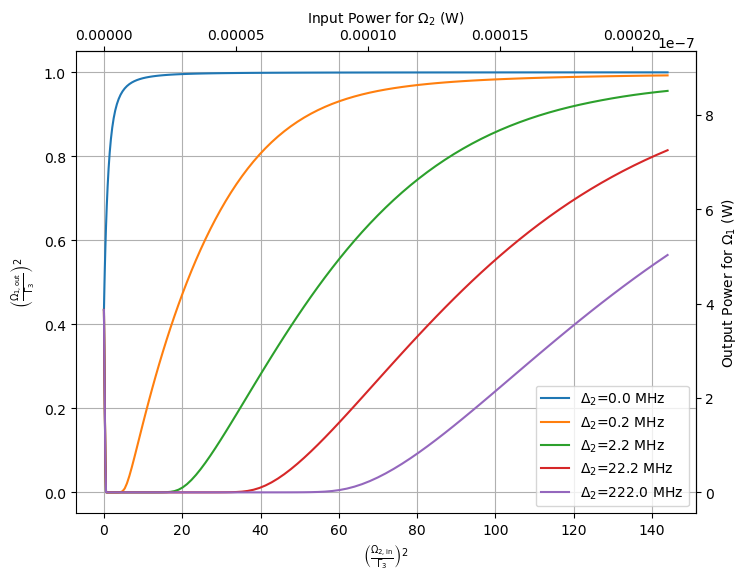

In [41]:
# Suppose mu_2 is mu_23 for Omega_2, mu_1 is mu_13 for Omega_1
K_2 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_23**2)
K_1 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)

# For the X-axis (which is Omega_2^2 -> power):
def x_forward(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2) # because P = K_2 * (omega2)^2
def x_inverse(power_value):
    return power_value / (K_2 * (Gamma3**2))
# For the Y-axis (which is Omega_1^2 -> power):
def y_forward(omega1_sq):
    return K_1 * omega1_sq * (Gamma3**2)
def y_inverse(power_value):
    return power_value / (K_1 * (Gamma3**2))
def y_forward_2(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2)  # Por ejemplo, si K_2 corresponde a la transición de Ω2
def y_inverse_2(power_value):
    return power_value / (K_2 * (Gamma3**2))

def plot_OD(Om_1, delta_1, delta_2):
    
    Output_Omega_1_list = np.array([[24.842872135961382, 25.051778112775757, 25.643761305969942, 26.532911562983745, 27.615593490723818, 28.793714977493526, 29.985140343063875, 31.126665902978747, 32.174174439869816, 33.10172252629501, 33.89940766660107, 34.569856581690374, 35.12394486957108, 35.57673208165874, 35.94434046931486, 36.24199501431769, 36.48305514149539, 36.67872111289116, 36.83812007986828, 36.96856323554505, 37.07585097027943, 37.16456417294974, 37.23831657261192, 37.2999623069354, 37.35176170994342, 37.395511512476254, 37.43264615105778, 37.46431624759325, 37.49144932708453, 37.51479683253718, 37.534970611304885, 37.55247132108277, 37.56771062952613, 37.58102863678235, 37.59270761000343, 37.602982860340326, 37.61205139702931, 37.62007884487891, 37.62720499910604, 37.63354830616128, 37.63920949424561, 37.64427452763008, 37.64881702085587, 37.65290021965469, 37.65657863281202, 37.659899381656466, 37.662903320206695, 37.6656259683074, 37.66809829168963, 37.67034735627565, 37.67239687878964, 37.67426769157812, 37.675978136200825, 37.67754439769811, 37.678980789285305, 37.6802999954992, 37.68151328041594, 37.682630666420096, 37.683661088076455, 37.68461252489666, 37.68549211616096, 37.6863062604525, 37.68706070212752, 37.687760606602254, 37.68841062603261, 37.689014956738575, 37.68957738950032, 37.69010135370161, 37.69058995614275, 37.691046015227876, 37.691472091133576, 37.69187051247299, 37.69224339990396, 37.692592687067695, 37.69292013918196, 37.69322736958446, 37.693515854472025, 37.6937869460482, 37.69404188427248, 37.6942818073718, 37.694507761258606, 37.69472070797963, 37.69492153330504, 37.69511105355453, 37.69529002174385, 37.69545913312693, 37.695619030199126, 37.695770307216165, 37.69591351428567, 37.69604916107012, 37.696177720146174, 37.69629963005239, 37.69641529805907, 37.69652510268655, 37.6966293959985, 37.69672850569075, 37.69682273699901, 37.69691237443625, 37.69699768338378, 37.69707891154638], [24.842872135961382, 24.38103256720482, 22.97172179166292, 20.51312678386769, 16.749109495110154, 11.024770618160684, 1.1808674218802648, 0.0026328594501581135, 0.002108195641503334, 0.0029398395391985817, 0.0049811116677373375, 0.009345277264182184, 0.01873058144884706, 0.03924224527597296, 0.08439042909120079, 0.18641409732223718, 0.41711050296529395, 0.9319491388413816, 1.9778039149005888, 3.6133210888898573, 5.513550751139206, 7.4055118018441375, 9.194620087973327, 10.86203504011078, 12.412139985652978, 13.855555902833077, 15.20376718573651, 16.467425191501665, 17.65588670065761, 18.777181691895496, 19.838125123795994, 20.844467187007517, 21.801043006526463, 22.711908504975973, 23.580459232286447, 24.40953280045679, 25.20149683353697, 25.958324574201878, 26.68166012131428, 27.37287498020247, 28.033117302036448, 28.663354914000923, 29.264413010848013, 29.837007191055893, 30.38177237243126, 30.89928800644905, 31.39009992182661, 31.854739060363766, 32.29373731735865, 32.707640661126774, 33.09701967820787, 33.462477670261556, 33.804656413414094, 34.12423967944809, 34.42195460987962, 34.69857102912288, 34.95489878502119, 35.19178322418828, 35.410098972150365, 35.61074235820255, 35.79462325670367, 35.96265819328573, 36.11576954339324, 36.254902484627145, 36.38106611953938, 36.495347816053375, 36.59881251769623, 36.692339963517625, 36.77660306758327, 36.85224485134557, 36.92006226217904, 36.981008805123544, 37.0360268854096, 37.085871577587, 37.131068864197836, 37.172004536696946, 37.20903430152261, 37.242534516372196, 37.272892172716226, 37.300471786772405, 37.325592642025946, 37.34852726358099, 37.369511806018046, 37.3887553480194, 37.40644369429346, 37.42274045473018, 37.43778864934891, 37.45171339116766, 37.4646246546872, 37.476619476483, 37.48778362318003, 37.49819296360931, 37.50791468788578, 37.517008412323435, 37.52552716801833, 37.53351826821684, 37.54102405769258, 37.54808255420798, 37.55472799535504, 37.560991304497456], [24.842872135961382, 24.363145256372288, 22.892474267806286, 20.316763983936404, 16.368171263268046, 10.390678936784864, 0.8511135828646614, 0.0002479076794014369, 0.00010757054680380913, 9.067374055839203e-05, 9.702320350957963e-05, 0.0001131499578109452, 0.00014304619182743672, 0.00018718223348464336, 0.00025192646292130163, 0.0003489079645288466, 0.0004934273323983122, 0.0007087194437068244, 0.001031246639590983, 0.001517910830830433, 0.0022592597618940635, 0.0034036984757603345, 0.005181354433235343, 0.007916347040305501, 0.012210256330978064, 0.019047921899182415, 0.02975255188799714, 0.0470908065523018, 0.0747183039792154, 0.11940043164625971, 0.19254368666977917, 0.31138024046401397, 0.5050626922084741, 0.8190558240828881, 1.3127845903078699, 2.0363084416454296, 2.9844820301179493, 4.089275896263062, 5.271771931450582, 6.477973140938956, 7.678306887544222, 8.857896341345901, 10.009604997052312, 11.130273896179508, 12.218798132028803, 13.27513590328917, 14.299784974953791, 15.293499032725235, 16.257131338163017, 17.191548241142947, 18.097582191346824, 18.976007638466374, 19.827530436751506, 20.652785297309666, 21.45233803400496, 22.226690619032258, 22.97628781558317, 23.701524609523744, 24.402753942564562, 25.08029442572778, 25.734437824607596, 26.36545618104764, 26.973608484029697, 27.559146834774033, 28.122322072872176, 28.663388845303746, 29.182610110661752, 29.680261078286332, 30.156632587261992, 30.61203393393158, 31.046795159140828, 31.461268808085887, 31.855831176493417, 32.23088305700067, 32.58684999893995, 32.924182093181805, 33.24335329103465, 33.544860262111065, 33.8292207901506, 34.09697169744432, 34.3486662771051, 34.584871197272314, 34.80616282162408, 35.01312287222407, 35.20633330464829, 35.38637032910495, 35.55379856125989, 35.709159095285465, 35.85294534333635, 35.9856325074894, 36.10784681585389, 36.22054157782844, 36.32488479600782, 36.421833899507035, 36.5117805029814, 36.594617218889894, 36.67014518224744, 36.73847349735164, 36.8001821870805, 36.85623579351532], [24.842872135961382, 24.360134744284437, 22.87815144465679, 20.27838257049775, 16.289319218261433, 10.256948279575106, 0.8034026371100416, 0.0001557631700948674, 5.201554264166697e-05, 3.7160127276805547e-05, 3.2967930920240564e-05, 3.3445409741903556e-05, 3.566850953518667e-05, 3.9859718738727604e-05, 4.5937995443691944e-05, 5.423638977239608e-05, 6.472852672237658e-05, 7.946053031679784e-05, 9.754450039202725e-05, 0.00012120301910658605, 0.00015316529053925574, 0.00019491223717144632, 0.0002490318354249578, 0.00032013639079012134, 0.0004145995664820352, 0.0005408376444511934, 0.0007103201429353736, 0.0009390762083882236, 0.0012494996557026253, 0.0016717562442594895, 0.0022444823244647176, 0.003021388784072461, 0.00409667606247845, 0.005615551634044642, 0.0077082169322282975, 0.010590571216515358, 0.014761866830561668, 0.020522908521797157, 0.02881142037205583, 0.04059345005145081, 0.0575468148734481, 0.08185769270754623, 0.11753147899484345, 0.16854416595162192, 0.24442324722703263, 0.35486150933938854, 0.516226219668532, 0.7537875777396245, 1.0955576788483978, 1.571997058010612, 2.20310878566176, 2.980037601510905, 3.8684251933770977, 4.827319568373263, 5.823413293775635, 6.834265474833696, 7.845924526241042, 8.8499308999095, 9.84116476487848, 10.816512990131395, 11.774077182073876, 12.712704199702811, 13.63170417915918, 14.530678127973221, 15.409410636686761, 16.26780211859553, 17.10582557473599, 17.923498894421357, 18.720867181659962, 19.49799165509425, 20.25494291216276, 20.991797115553336, 21.708634143538696, 22.405537056457973, 23.082592434929367, 23.739891280743095, 24.37753026302119, 24.995613155192807, 25.594252352252816, 26.17357038881992, 26.733701400744266, 27.274792489126757, 27.79700495743305, 28.300515401092664, 28.785516635502916, 29.252218453200598, 29.700848204609112, 30.131651199455785, 30.54489092789784, 30.94084910173431, 31.319825516859606, 31.68213773841952, 32.028120609908804, 32.35812558666334, 32.67251989275848, 32.97168549804652, 33.25601790868709, 33.52592475959779, 33.781824191333946, 34.02414297841114], [24.842872135961382, 24.35959899901425, 22.875354009646294, 20.27031389057206, 16.272492020648425, 10.232355161809789, 0.8170174245635592, 0.00015477045288668964, 4.2942660424566986e-05, 2.759398681627968e-05, 2.2424758780972307e-05, 2.0444435264903916e-05, 2.0382428255750045e-05, 2.0980222701449742e-05, 2.2085465929437433e-05, 2.431973266074668e-05, 2.6585825461745443e-05, 3.0183660342927094e-05, 3.393502789394269e-05, 3.9363857085116315e-05, 4.5112659203780806e-05, 5.3008039399079205e-05, 6.22381193462567e-05, 7.310486012031263e-05, 8.748311696500473e-05, 0.00010478450704191179, 0.00012519998182227517, 0.00015083266877292373, 0.0001835124543074889, 0.00022440309567257235, 0.00027504737142635847, 0.00033800733035969054, 0.0004169272783923843, 0.0005165581691992219, 0.0006430005593504107, 0.0008041216828538648, 0.0010099948875376382, 0.0012732166764498492, 0.0016093676683245877, 0.002039282333939349, 0.0025958058280997082, 0.003331488279293042, 0.0043088390832807955, 0.005573450508034122, 0.0071980219825988345, 0.009396865254292478, 0.012375083564540229, 0.016197027387538237, 0.021420166550390758, 0.028557942827177437, 0.037842559218237044, 0.05100812902664891, 0.06830713314316945, 0.09263245917043693, 0.12546434546653792, 0.17136699406108122, 0.2341733159104308, 0.322517141595448, 0.443511969712509, 0.6144941760278815, 0.8471662301050922, 1.1687638164036358, 1.5941369342292329, 2.1400762501575734, 2.8031642074434306, 3.564489050195954, 4.397571703964752, 5.2763886200387695, 6.180983798262393, 7.097339386912117, 8.016068184192816, 8.930952204526827, 9.837850879315383, 10.73397321504899, 11.617409497931094, 12.486832719668948, 13.34130697928131, 14.180163026910979, 15.002916277445479, 15.809212050512246, 16.59878854192802, 17.371451530797508, 18.12705697531373, 18.865498987445125, 19.586701521573488, 20.29061265467443, 20.9772006896864, 21.646451548454625, 22.29836707868082, 22.932964007278674, 23.550273347337274, 24.150340118405385, 24.733223277148017, 25.298995782281075, 25.847744737232116, 26.379571568331922, 26.894592207013293, 27.39293725245273, 27.87475209712383, 28.34019700227513]])
    Om_2_list_adapted = ([0j, (4.569589314312426+0j), (9.139178628624853+0j), (13.708767942937278+0j), (18.278357257249706+0j), (22.847946571562133+0j), (27.417535885874557+0j), (31.987125200186984+0j), (36.55671451449941+0j), (41.126303828811835+0j), (45.695893143124266+0j), (50.26548245743669+0j), (54.835071771749114+0j), (59.404661086061544+0j), (63.97425040037397+0j), (68.5438397146864+0j), (73.11342902899882+0j), (77.68301834331125+0j), (82.25260765762367+0j), (86.82219697193611+0j), (91.39178628624853+0j), (95.96137560056096+0j), (100.53096491487338+0j), (105.1005542291858+0j), (109.67014354349823+0j), (114.23973285781067+0j), (118.80932217212309+0j), (123.37891148643551+0j), (127.94850080074794+0j), (132.51809011506037+0j), (137.0876794293728+0j), (141.65726874368522+0j), (146.22685805799765+0j), (150.79644737231007+0j), (155.3660366866225+0j), (159.93562600093492+0j), (164.50521531524734+0j), (169.07480462955976+0j), (173.64439394387222+0j), (178.21398325818464+0j), (182.78357257249706+0j), (187.3531618868095+0j), (191.9227512011219+0j), (196.49234051543434+0j), (201.06192982974676+0j), (205.63151914405918+0j), (210.2011084583716+0j), (214.77069777268403+0j), (219.34028708699645+0j), (223.9098764013089+0j), (228.47946571562133+0j), (233.04905502993375+0j), (237.61864434424618+0j), (242.1882336585586+0j), (246.75782297287103+0j), (251.32741228718345+0j), (255.89700160149587+0j), (260.4665909158083+0j), (265.03618023012075+0j), (269.60576954443314+0j), (274.1753588587456+0j), (278.744948173058+0j), (283.31453748737044+0j), (287.88412680168284+0j), (292.4537161159953+0j), (297.02330543030774+0j), (301.59289474462014+0j), (306.1624840589326+0j), (310.732073373245+0j), (315.30166268755744+0j), (319.87125200186983+0j), (324.4408413161823+0j), (329.0104306304947+0j), (333.58001994480713+0j), (338.14960925911953+0j), (342.719198573432+0j), (347.28878788774443+0j), (351.85837720205683+0j), (356.4279665163693+0j), (360.9975558306817+0j), (365.56714514499413+0j), (370.1367344593065+0j), (374.706323773619+0j), (379.2759130879314+0j), (383.8455024022438+0j), (388.4150917165562+0j), (392.98468103086867+0j), (397.5542703451811+0j), (402.1238596594935+0j), (406.69344897380597+0j), (411.26303828811837+0j), (415.8326276024308+0j), (420.4022169167432+0j), (424.97180623105567+0j), (429.54139554536806+0j), (434.1109848596805+0j), (438.6805741739929+0j), (443.25016348830536+0j), (447.8197528026178+0j), (452.3893421169302+0j)])
    
    Gamma12_list = np.array([1, 10, 100, 1000, 10000])*2.22e-2
    
    fig, ax1 = plt.subplots(figsize=(8,6))
    for i in range(len(Output_Omega_1_list)):
        ax1.plot((np.real(Om_2_list_adapted))**2/Gamma3**2,
                 (Output_Omega_1_list[i])**2/Gamma3**2,
                 label=f'$\\Delta_2$={Gamma12_list[i]:.1f} MHz')

    ax1.set_xlabel(r'$\left(\frac{\Omega_{2,\mathrm{in}}}{\Gamma_3}\right)^2$')
    ax1.set_ylabel(r'$\left(\frac{\Omega_{1,\mathrm{out}}}{\Gamma_3}\right)^2$')
    ax1.grid(True)
    ax1.legend(loc='best')

    # Create the top X-axis for power of Omega_2:
    ax_top = ax1.secondary_xaxis('top', functions=(x_forward, x_inverse))
    ax_top.set_xlabel('Input Power for $\\Omega_2$ (W)')

    # Create the right Y-axis for power of Omega_1:
    ax_right = ax1.secondary_yaxis('right', functions=(y_forward, y_inverse))
    ax_right.set_ylabel('Output Power for $\\Omega_1$ (W)')
    # Save the figure to the specified path
    save_path = r"C:\Users\ruben\OneDrive\Escritorio\Purdue\AONN Research\Paper Figures\Figure5a.pdf"
    plt.savefig(save_path, format='eps', dpi=300)
    plt.show()
    

# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_1 = np.array([1])*Gamma3
    delta_1 = [0]
    delta_2 = np.array([0.15])*Gamma3
    
    # Call the plot_OD function with these values
    plot_OD(Om_1, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(run_button)

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


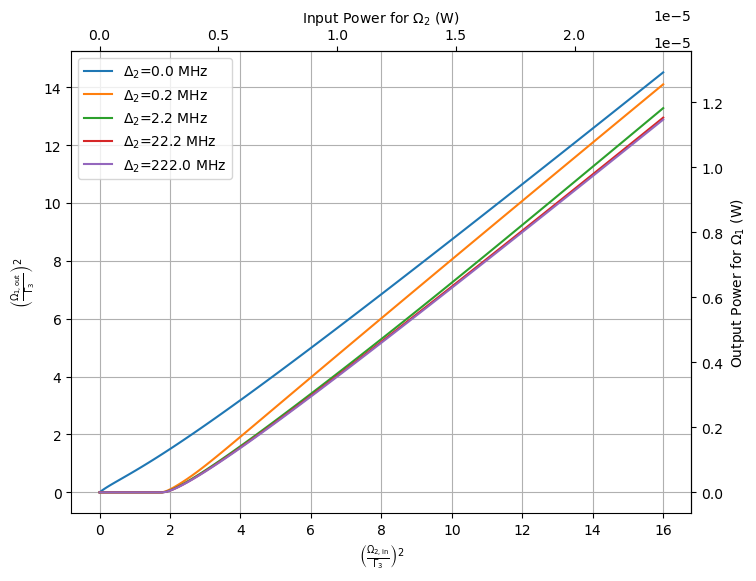

In [18]:
# Suppose mu_2 is mu_23 for Omega_2, mu_1 is mu_13 for Omega_1
K_2 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_23**2)
K_1 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)

# For the X-axis (which is Omega_2^2 -> power):
def x_forward(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2) # because P = K_2 * (omega2)^2
def x_inverse(power_value):
    return power_value / (K_2 * (Gamma3**2))
# For the Y-axis (which is Omega_1^2 -> power):
def y_forward(omega1_sq):
    return K_1 * omega1_sq * (Gamma3**2)
def y_inverse(power_value):
    return power_value / (K_1 * (Gamma3**2))
def y_forward_2(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2)  # Por ejemplo, si K_2 corresponde a la transición de Ω2
def y_inverse_2(power_value):
    return power_value / (K_2 * (Gamma3**2))

def plot_OD(Om_1, delta_1, delta_2):
    
    Output_Omega_1_list = np.array([[0.0, 1.5112949253348533, 3.0155596931221114, 4.506047187170165, 5.976732115528249, 7.4227769532964345, 8.840834116946912, 10.229132980014892, 11.587395670950318, 12.916643634760607, 14.218947596971203, 15.497160743085464, 16.754662955268987, 17.9951333089125, 19.222359271754396, 20.44008461343089, 21.651893929157385, 22.861129519174813, 24.070835581061587, 25.283724721265948, 26.502162258161345, 27.7281644033279, 28.963407025389373, 30.209242257997282, 31.466720692150027, 32.736617295386154, 34.01945953654906, 35.315556476674146, 36.62502782546776, 37.94783216885513, 39.28379375393818, 40.63262737874643, 41.99396107813025, 43.367356424685156, 44.752326374171425, 46.148350677440696, 47.55488895474277, 48.97139158351321, 50.39730858834158, 51.83209674362411, 53.27522510781042, 54.7261792059397, 56.18446406697037, 57.649606306856555, 59.121155429529274, 60.59868449768698, 62.08179030493581, 63.5700931612763, 65.06323638585425, 66.56088558459969, 68.06272777604273, 69.56847041620549, 71.07784036294385, 72.59058281126717, 74.10646022387748, 75.62525127518475, 77.1467498222033, 78.6707639118912, 80.19711483140433, 81.72563620534457, 83.25617314224009, 84.78858143105064, 86.32272678746898, 87.85848414897856, 89.39573701710313, 90.93437684487193, 92.47430246731771, 94.01541957265222, 95.55764021172503, 97.10088234335377, 98.64506941317316, 100.1901299636925, 101.73599727338491, 103.28260902269409, 104.82990698498979, 106.3778367406127, 107.92634741225666, 109.47539142006998, 111.02492425496301, 112.57490426871189, 114.12529247956803, 115.6760523921596, 117.22714983059123, 118.77855278369871, 120.33023126153097, 121.88215716218245, 123.43430414817955, 124.98664753167785, 126.53916416780741, 128.09183235552248, 129.64463174540649, 131.1975432538833, 132.75054898337018, 134.3036321479044, 135.8567770038586, 137.409968785348, 138.96319364398843, 140.5164385926873, 142.06969145317584, 143.622940806995],[0.0, 2.0185227441182627e-07, 4.2696074284805314e-07, 6.996370948789844e-07, 1.0473994814090176e-06, 1.5042427995758908e-06, 2.1149006865526467e-06, 2.9405032119754867e-06, 4.066495240028977e-06, 5.614067805808044e-06, 7.756834849934108e-06, 1.0745251880496483e-05, 1.4942741185378792e-05, 2.0880538159142524e-05, 2.9344248339758245e-05, 4.151521749341024e-05, 5.9203987806547024e-05, 8.522979061686013e-05, 0.00012402079225160283, 0.00018255440900832366, 0.000271891306038463, 0.0004099133932386591, 0.000626614730250668, 0.000974518223695123, 0.0015486951256071292, 0.002524586274894986, 0.004231843141358555, 0.007313036669358639, 0.013109520167709486, 0.024710990533466967, 0.05019753467867378, 0.11503433705487144, 0.3332027248117555, 1.8335646525676894, 7.417416208790328, 12.071340163930287, 15.94467243291343, 19.390125955655314, 22.567609782871653, 25.56573233802648, 28.4400412338573, 31.223089535610818, 33.93247661971854, 36.57505729331808, 39.15304266272803, 41.66770757847813, 44.12108558618217, 46.516170748571724, 48.85660761537712, 51.14632210960442, 53.38924754415661, 55.589157060163465, 57.74957604565523, 59.873746146266, 61.964619743455515, 64.02487109430699, 66.05691569160099, 68.06293290963072, 70.04488917009087, 72.00456016117707, 73.94355140222666, 75.86331687938784, 77.76517571701083, 79.65032697485964, 81.51986272076131, 83.37477955047129, 85.21598872817253, 87.04432511195733, 88.86055501463356, 90.66538313439744, 92.45945867415641, 94.24338075345638, 96.01770320346955, 97.7829388235206, 99.5395631670614, 101.28801791586099, 103.02871389323252, 104.76203376028188, 106.48833443327877, 108.20794925521089, 109.92118995021649, 111.62834838588032, 113.32969816516133, 115.02549606696202, 116.71598335195944, 118.40138694828434, 120.08192052982946, 121.75778549845748, 123.4291718800256, 125.09625914298732, 126.75921694732979, 128.41820583071149, 130.0733778379069, 131.72487709897763, 133.37284036100928, 135.01739747772947, 136.6586718608561, 138.296780896642, 139.93183633070433, 141.56394462391674],[0.0, 1.5507477878532807e-07, 3.1625206633859795e-07, 4.898189434859134e-07, 6.824745855343843e-07, 9.01630715525838e-07, 1.1558016355855159e-06, 1.4550974726582714e-06, 1.8118423478369795e-06, 2.2413540206749344e-06, 2.7629407702891285e-06, 3.4011970250505245e-06, 4.187718503988369e-06, 5.163422961996302e-06, 6.381774690437639e-06, 7.91340244796641e-06, 9.852922020263492e-06, 1.232930388253224e-05, 1.5521988014175563e-05, 1.9686359029161423e-05, 2.5194573116170634e-05, 3.260193999609987e-05, 4.275700111986125e-05, 5.6989449150396135e-05, 7.744463458673121e-05, 0.00010771400440779889, 0.00015411501315220407, 0.00022854649041265676, 0.0003556749959770675, 0.0005942083453994156, 0.0011168394141253706, 0.002658485429527785, 0.012466773691093723, 0.6814909039828809, 5.461008433995237, 9.830253637371316, 13.566829570733255, 16.912604556053132, 19.99173780331818, 22.875482601561853, 25.608872476167473, 28.22243878272468, 30.737986599295482, 33.17169326947391, 35.53590944870649, 37.84030551316696, 40.09263339002741, 42.299215515554856, 44.465263742940394, 46.59512601928507, 48.69248807327703, 50.76050895903087, 52.80190110862643, 54.819008368472005, 56.813896895965044, 58.788394805949544, 60.74409495300366, 62.682432420106615, 64.60472295286998, 66.51210610945066, 68.4056495327858, 70.28636391328592, 72.1551027398355, 74.01275813349409, 75.86013209559448, 77.69794970687597, 79.52703754910257, 81.34803515684402, 83.16172312956515, 84.96876350791221, 86.76982077283336, 88.56555687180153, 90.35649834943237, 92.14318623050933, 93.92598418887239, 95.70522223623212, 97.48108372988168, 99.25369371853625, 101.02308689280144, 102.78925478504429, 104.55214876689564, 106.31170356228003, 108.06784565397376, 109.82050369699546, 111.56961354391296, 113.31512189308711, 115.05698787065876, 116.79518352938162, 118.52969354910816, 120.2605144627491, 121.98765362434087, 123.71112805667032, 125.4309632757087, 127.14719214873271, 128.8598538208008, 130.568992727472, 132.27465770119153, 133.97690117205417, 135.6757784595603, 137.37134714966734], [0.0, 1.483674210327602e-07, 3.005409374619502e-07, 4.604274958767029e-07, 6.321495882699721e-07, 8.201856479312382e-07, 1.029545824170073e-06, 1.2659924196742318e-06, 1.5363165823878875e-06, 1.8486878179591913e-06, 2.2131004106495905e-06, 2.6419514181776025e-06, 3.1508000615456596e-06, 3.759380978203735e-06, 4.492978984551746e-06, 5.384329321522253e-06, 6.476299779579328e-06, 7.825766046463207e-06, 9.509356998313888e-06, 1.1632212046786527e-05, 1.4341732218982794e-05, 1.7849875020916413e-05, 2.2470601948530243e-05, 2.868537379946203e-05, 3.726334529521745e-05, 4.9495364168474035e-05, 6.768475864765095e-05, 9.628079302209801e-05, 0.00014485542403602563, 0.0002374613421193287, 0.0004512272064633955, 0.0011708221294999504, 0.007945901697635831, 0.6456601867450027, 5.0255909145328665, 9.289754029887174, 12.983330833391353, 16.30652454414341, 19.37222843262422, 22.247335647290974, 24.974851098969015, 27.584217693755473, 30.096582096391206, 32.527714168481374, 34.88973377486069, 37.192181563873554, 39.44271024349079, 41.647553292130276, 43.8118613953845, 45.93995166363642, 48.035488039251874, 50.101606090852584, 52.14100274029976, 54.156012420365734, 56.14867660423968, 58.12079794407032, 60.07397319272279, 62.00961578376126, 63.928983114065005, 65.83320646179048, 67.72330948317082, 69.60021457701305, 71.46475250691809, 73.3176802982137, 75.15969354568914, 76.99142713368869, 78.81345830448467, 80.62631906751706, 82.4305042592436, 84.22646881094266, 86.01462916987714, 87.79537456500134, 89.5690707082732, 91.33605286662142, 93.09663101373785, 94.85110241733727, 96.59974359299376, 98.34280509146731, 100.08053149035106, 101.81315559747829, 103.54088204983876, 105.26391647164587, 106.98245854163719, 108.69667552579922, 110.40674819754597, 112.1128484384615, 113.81511369564384, 115.51371535324893, 117.20879379382541, 118.90047368520622, 120.58892419266627, 122.27424719297342, 123.95658917217227, 125.63609206328283, 127.31284782404228, 128.98703451703472, 130.6587357590301, 132.32810623703008, 133.99527631200542, 135.66034870979632],[0.0, 1.4982178252914654e-07, 3.028923223441608e-07, 4.6253427460380346e-07, 6.322269314390158e-07, 8.1570588425559e-07, 1.0170869252936514e-06, 1.2410217123978842e-06, 1.4928946021570181e-06, 1.779073952662786e-06, 2.1072373817760163e-06, 2.486799526158915e-06, 2.9294840134266945e-06, 3.450100873983254e-06, 4.067620306809111e-06, 4.806680081047205e-06, 5.699738186595363e-06, 6.790204777139227e-06, 8.137095080861518e-06, 9.822108609181582e-06, 1.1960700256691487e-05, 1.4719957434764086e-05, 1.8348570759706795e-05, 2.3229356925524263e-05, 2.9976311772491144e-05, 3.962585906653069e-05, 5.404499425126153e-05, 7.689553234530216e-05, 0.00011624071743823272, 0.00019305127476682018, 0.00037812011825305613, 0.0010549457484299591, 0.0086033435910541, 0.6579406219978088, 4.896438646561332, 9.103454321392773, 12.769134280264252, 16.07555803516261, 19.130034025594483, 21.997095756127912, 24.71856793666731, 27.323239111156482, 29.83186178914708, 32.259945156632, 34.61942034354659, 36.919687521471054, 39.168302219277294, 41.37143950014867, 43.534215971804024, 45.66091933973642, 47.755178011852934, 49.820091435715504, 51.85833256532236, 53.87222746464386, 55.86381474915432, 57.83488898309878, 59.78703450678206, 61.72165585178706, 63.64000678930839, 65.54321527741776, 67.43230075806908, 69.30818444293756, 71.1716979239538, 73.02359481851339, 74.86456419009433, 76.69524016897167, 78.51620527531337, 80.3279919058195, 82.1310878830274, 83.92594521748478, 85.71298555942046, 87.49259984221206, 89.26514783734366, 91.03096296967855, 92.79035871818704, 94.5436297575789, 96.29104940776989, 98.03287102976141, 99.76933373188123, 101.50066462975985, 103.2270759169187, 104.94876454769798, 106.66591719224748, 108.37871260820444, 110.08731838556746, 111.79189029053805, 113.49257716847347, 115.189522505073, 116.88286033821916, 118.57271561633588, 120.25920973671154, 121.94245969947858, 123.62257317430313, 125.29965239093792, 126.97379911933363, 128.64510843697002, 130.31366715361486, 131.97956315670922, 133.6428817025782, 135.3036974531492]])
    Om_1_list_adapted = np.array([0j, (1.523196438104142+0j), (3.046392876208284+0j), (4.569589314312426+0j), (6.092785752416568+0j), (7.61598219052071+0j), (9.139178628624853+0j), (10.662375066728995+0j), (12.185571504833137+0j), (13.708767942937278+0j), (15.23196438104142+0j), (16.755160819145562+0j), (18.278357257249706+0j), (19.801553695353846+0j), (21.32475013345799+0j), (22.84794657156213+0j), (24.371143009666273+0j), (25.894339447770417+0j), (27.417535885874557+0j), (28.9407323239787+0j), (30.46392876208284+0j), (31.987125200186984+0j), (33.510321638291124+0j), (35.03351807639527+0j), (36.55671451449941+0j), (38.079910952603555+0j), (39.60310739070769+0j), (41.126303828811835+0j), (42.64950026691598+0j), (44.17269670502012+0j), (45.69589314312426+0j), (47.2190895812284+0j), (48.742286019332546+0j), (50.26548245743669+0j), (51.78867889554083+0j), (53.31187533364497+0j), (54.835071771749114+0j), (56.35826820985326+0j), (57.8814646479574+0j), (59.40466108606154+0j), (60.92785752416568+0j), (62.451053962269825+0j), (63.97425040037397+0j), (65.49744683847811+0j), (67.02064327658225+0j), (68.5438397146864+0j), (70.06703615279054+0j), (71.59023259089467+0j), (73.11342902899882+0j), (74.63662546710296+0j), (76.15982190520711+0j), (77.68301834331125+0j), (79.20621478141538+0j), (80.72941121951953+0j), (82.25260765762367+0j), (83.7758040957278+0j), (85.29900053383196+0j), (86.8221969719361+0j), (88.34539341004024+0j), (89.86858984814438+0j), (91.39178628624852+0j), (92.91498272435267+0j), (94.4381791624568+0j), (95.96137560056096+0j), (97.48457203866509+0j), (99.00776847676923+0j), (100.53096491487338+0j), (102.05416135297752+0j), (103.57735779108167+0j), (105.1005542291858+0j), (106.62375066728994+0j), (108.14694710539409+0j), (109.67014354349823+0j), (111.19333998160238+0j), (112.71653641970651+0j), (114.23973285781065+0j), (115.7629292959148+0j), (117.28612573401894+0j), (118.80932217212307+0j), (120.33251861022723+0j), (121.85571504833136+0j), (123.37891148643551+0j), (124.90210792453965+0j), (126.42530436264379+0j), (127.94850080074794+0j), (129.47169723885207+0j), (130.99489367695622+0j), (132.51809011506035+0j), (134.0412865531645+0j), (135.56448299126865+0j), (137.0876794293728+0j), (138.61087586747692+0j), (140.13407230558107+0j), (141.65726874368522+0j), (143.18046518178934+0j), (144.7036616198935+0j), (146.22685805799765+0j), (147.75005449610177+0j), (149.27325093420592+0j), (150.79644737231007+0j)])
    Gamma12_list = np.array([1, 10, 100, 1000, 10000])*2.22e-2
    
    fig, ax1 = plt.subplots(figsize=(8,6))
    for i in range(len(Output_Omega_1_list)):
        ax1.plot((np.real(Om_1_list_adapted))**2/Gamma3**2,
                 (Output_Omega_1_list[i])**2/Gamma3**2,
                 label=f'$\\Delta_2$={Gamma12_list[i]:.1f} MHz')

    ax1.set_xlabel(r'$\left(\frac{\Omega_{2,\mathrm{in}}}{\Gamma_3}\right)^2$')
    ax1.set_ylabel(r'$\left(\frac{\Omega_{1,\mathrm{out}}}{\Gamma_3}\right)^2$')
    ax1.grid(True)
    ax1.legend(loc='best')

    # Create the top X-axis for power of Omega_2:
    ax_top = ax1.secondary_xaxis('top', functions=(x_forward, x_inverse))
    ax_top.set_xlabel('Input Power for $\\Omega_2$ (W)')

    # Create the right Y-axis for power of Omega_1:
    ax_right = ax1.secondary_yaxis('right', functions=(y_forward, y_inverse))
    ax_right.set_ylabel('Output Power for $\\Omega_1$ (W)')
    # Save the figure to the specified path
    save_path = r"C:\Users\ruben\OneDrive\Escritorio\Purdue\AONN Research\Paper Figures\Figure5c(zoomed).pdf"
    plt.savefig(save_path, format='eps', dpi=300)
    plt.show()
    

# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_1 = np.array([1])*Gamma3
    delta_1 = [0]
    delta_2 = np.array([0.15])*Gamma3
    
    # Call the plot_OD function with these values
    plot_OD(Om_1, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(run_button)